In [7]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import Libraries

## Since we are storing big amounts of data it's best to try to reduce memory usage as much as possible

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

# Loading and Preprocessing data

In [21]:
train = import_data('train.csv')
test = import_data('test.csv')

y_lab = train['label']
y = tf.keras.utils.to_categorical(y_lab) 
train.drop('label', axis=1, inplace=True)

Memory usage of dataframe is 251.54 MB
Memory usage after optimization is: 58.32 MB
Decreased by 76.8%
Memory usage of dataframe is 167.48 MB
Memory usage after optimization is: 38.59 MB
Decreased by 77.0%


In [22]:
train_df = np.array(train).reshape(-1, 28, 28, 1)
test_df = np.array(test).reshape(-1, 28, 28, 1)

del train
del test
del y_lab

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size(image):
    img = array_to_img(image, scale=False) 
    img = img.resize((75, 75))
    img = img.convert(mode='RGB')
    arr = img_to_array(img)
    return arr.astype(np.float32)

In [24]:
train_array = [change_size(img) for img in train_df]
train = np.array(train_array)
del train_array

test_array = [change_size(img) for img in test_df]
test = np.array(test_array)

test = test / 255

del test_array

# Data Augmentation

<h2>
<strong>Data augmentation</strong> is useful to improve performance and outcomes of machine learning models by forming new and different examples to train datasets. If dataset in a machine learning model is rich and sufficient, the model performs better and more accurate. For example, classic image processing activities for data augmentation are
<ul>
<li>padding</li>
<li>random rotating</li>
<li>re-scaling,</li>
<li>vertical and horizontal flipping</li>
<li>translation ( image is moved along X, Y direction)</li>
<li>cropping</li>
<li>zooming</li>
<li>darkening & brightening/color modification</li>
<li>grayscaling</li>
<li>changing contrast</li>
<li>adding noise</li>
<li>random erasing</li>
</ul>
</h2>

In [25]:
image_gen = ImageDataGenerator(rescale=1./255,#easier for network to interpret numbers in range [0,1]
                              featurewise_center=False,
                              samplewise_center=False,
                              featurewise_std_normalization=False,
                              samplewise_std_normalization=False,
                              zca_whitening=False,
                              zoom_range=0.1,
                              rotation_range=10,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.3,
                              validation_split=0.2) # 80/20 train/val split

train_generator = image_gen.flow(train, 
                                 y,
                                batch_size=32,
                                shuffle=True,
                                subset='training',
                                seed=42)
valid_generator = image_gen.flow(train,
                                 y,
                                batch_size=16,
                                shuffle=True,
                                subset='validation')

del train_df
del test_df
del train

# Transfer Learning model
<h2>
It is common to perform <STRONG>transfer learning</STRONG> with predictive modeling problems that use image data as input.
<br><br>
This may be a prediction task that takes photographs or video data as input.
<br><br>
For these types of problems, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the ImageNet 1000-class photograph classification competition.
<br><br>
So, we will use Resnet-50 for our network architecture as it achieves state of the art result for our classification task
</h2>

In [15]:
model = Sequential()

model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3),
                                pooling = 'avg',
                                include_top = False, 
                                weights = 'imagenet'))

model.add(L.Flatten())
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False

In [29]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=3, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size)

1050/1050 [==============================] - 60s 57ms/step - loss: 0.0308 - accuracy: 0.9925 - val_loss: 0.1173 - val_accuracy: 0.9875


# Predictions and storing outputs

In [30]:
res = model.predict(test[:])
output = pd.DataFrame({'ImageId':[ i+1 for i in range(len(res))], 
                       'Label': [ xi.argmax() for xi in res]})
output.to_csv('result.csv', index=False)

predicted:  2


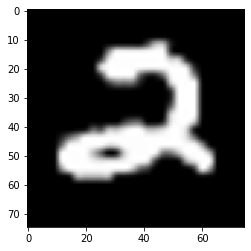

predicted:  0


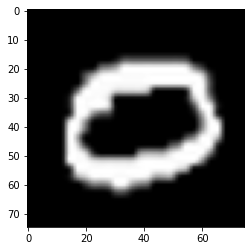

predicted:  9


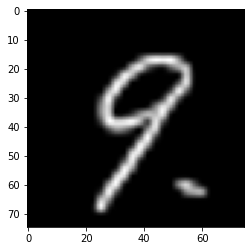

predicted:  0


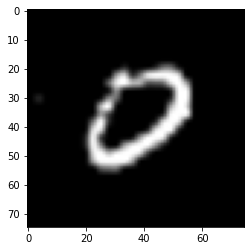

predicted:  3


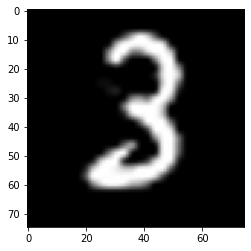

In [28]:
for i in range(5):
    print("predicted: ",res[i].argmax())
    plt.imshow(test[i],cmap="gray")
    plt.show()